# Import Libraries

In [146]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [147]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Residuals
import pylab
import scipy.stats as stats

#Homoscedasticity
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Functions

These functions have been copied from 'FAQ - Intro to Supervised Learning - Linear Regression' in the Predictive Modeling course.

In [148]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined
    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="brown", linestyle="-"
    )  # Add median to the histogram
    plt.show()


In [149]:
def labeled_barplot(data, feature, perc=False, n=None, custom_order=[]):
    """
    Barplot with percentage at the top
    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    custom_order: list of categories in the order you want
    """
    total = len(data[feature])  # length of the column
    count = data[feature].nunique()

    if len(custom_order) == 0:
        custom_order = data[feature].value_counts().index[:n]
    else:
        custom_order = custom_order

    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))
    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=custom_order,
    )
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category
        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot
        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.show()  # show the plot

# Import Data and Data Overview

In [150]:
df_ott = pd.read_csv('ottdata.csv')

In [151]:
df_ott.head()

,visitors,ad_impressions,major_sports_event,genre,dayofweek,season,views_trailer,views_content
0,1.67,1113.81,0,Horror,Wednesday,Spring,56.70,0.51
1,1.46,1498.41,1,Thriller,Friday,Fall,52.69,0.32
2,1.47,1079.19,1,Thriller,Wednesday,Fall,48.74,0.39
3,1.85,1342.77,1,Sci-Fi,Friday,Fall,49.81,0.44
4,1.46,1498.41,0,Sci-Fi,Sunday,Winter,55.83,0.46


In [152]:
df_ott.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   visitors            1000 non-null   float64
 1   ad_impressions      1000 non-null   float64
 2   major_sports_event  1000 non-null   int64  
 3   genre               1000 non-null   object 
 4   dayofweek           1000 non-null   object 
 5   season              1000 non-null   object 
 6   views_trailer       1000 non-null   float64
 7   views_content       1000 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 62.6+ KB


In [153]:
df_ott.describe().T

,count,mean,std,min,25%,50%,75%,max
visitors,1000.0,1.70429,0.231973,1.25,1.5500,1.70,1.830,2.34
ad_impressions,1000.0,1434.71229,289.534834,1010.87,1210.3300,1383.58,1623.670,2424.20
major_sports_event,1000.0,0.40000,0.490143,0.00,0.0000,0.00,1.000,1.00
views_trailer,1000.0,66.91559,35.001080,30.08,50.9475,53.96,57.755,199.92
views_content,1000.0,0.47340,0.105914,0.22,0.4000,0.45,0.520,0.89


In [154]:
df_ott['genre'].value_counts()

genre
Others      255
Comedy      114
Thriller    113
Drama       109
Romance     105
Sci-Fi      102
Horror      101
Action      101
Name: count, dtype: int64

In [155]:
df_ott['season'].value_counts()

season
Winter    257
Fall      252
Spring    247
Summer    244
Name: count, dtype: int64

In [156]:
df_ott['dayofweek'].value_counts()

dayofweek
Friday       369
Wednesday    332
Thursday      97
Saturday      88
Sunday        67
Monday        24
Tuesday       23
Name: count, dtype: int64

# Exploratory Data Analysis

## Univariate analysis

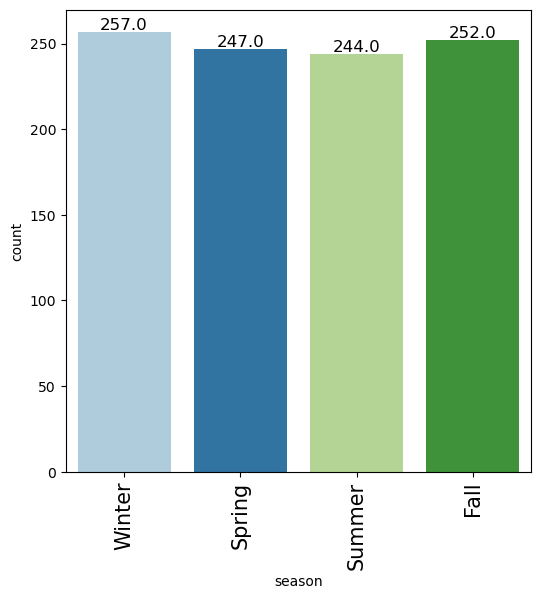

In [157]:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
labeled_barplot(data=df_ott, feature='season',custom_order=season_order)

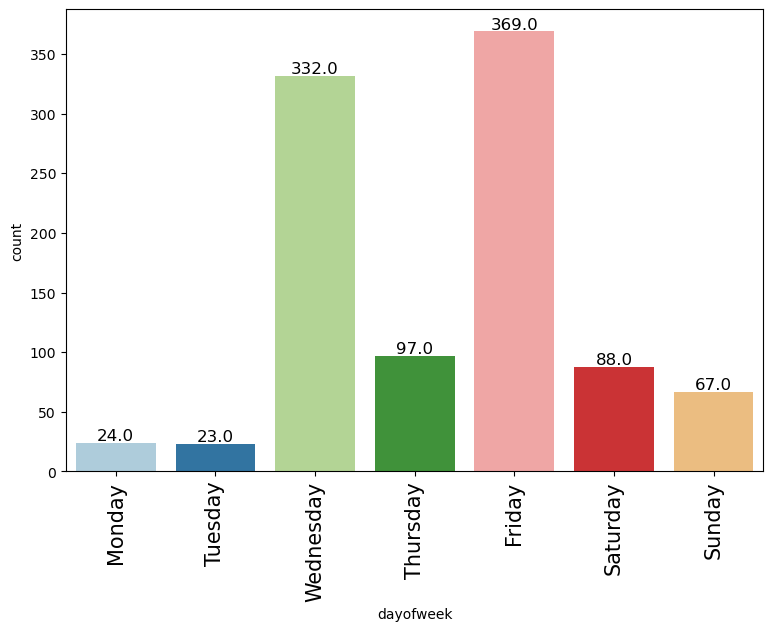

In [158]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
labeled_barplot(data=df_ott, feature='dayofweek', custom_order=days_order)

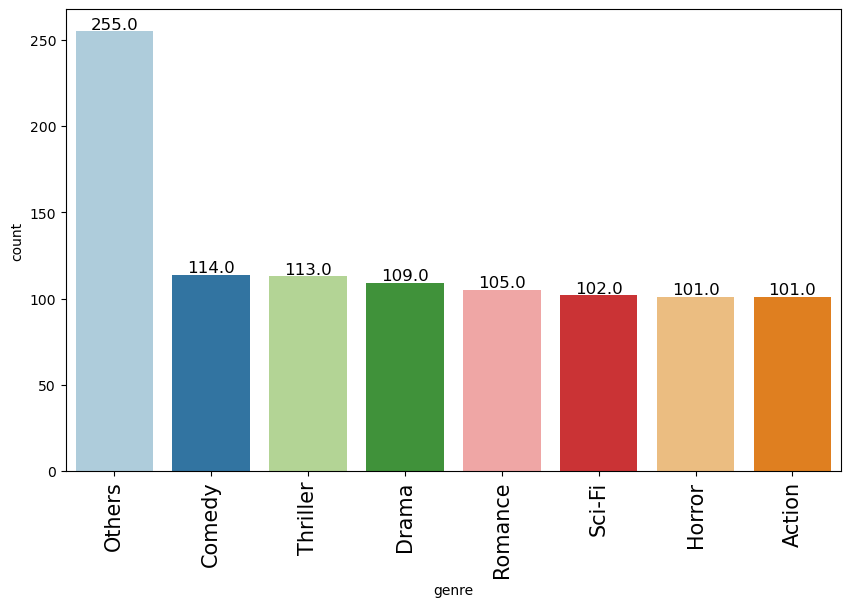

In [159]:
labeled_barplot(feature='genre', data=df_ott)

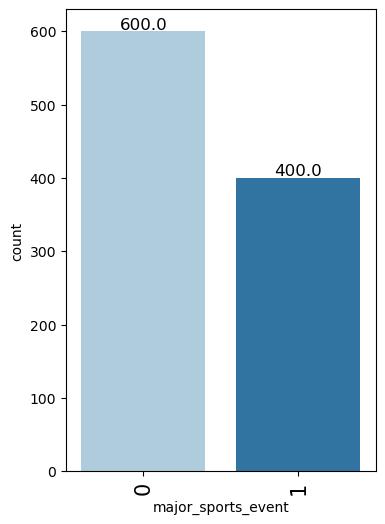

In [160]:
labeled_barplot(feature='major_sports_event', data=df_ott)

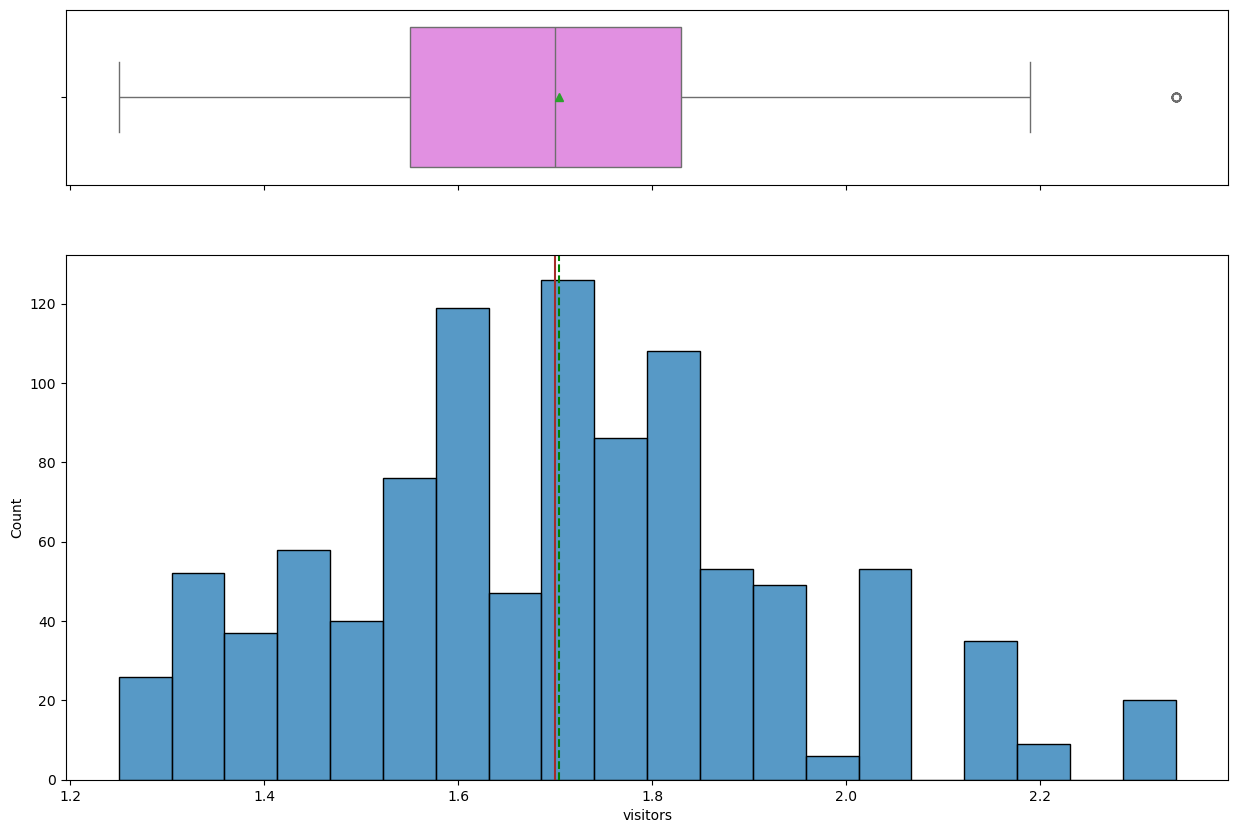

In [161]:
histogram_boxplot(data = df_ott, feature = 'visitors')

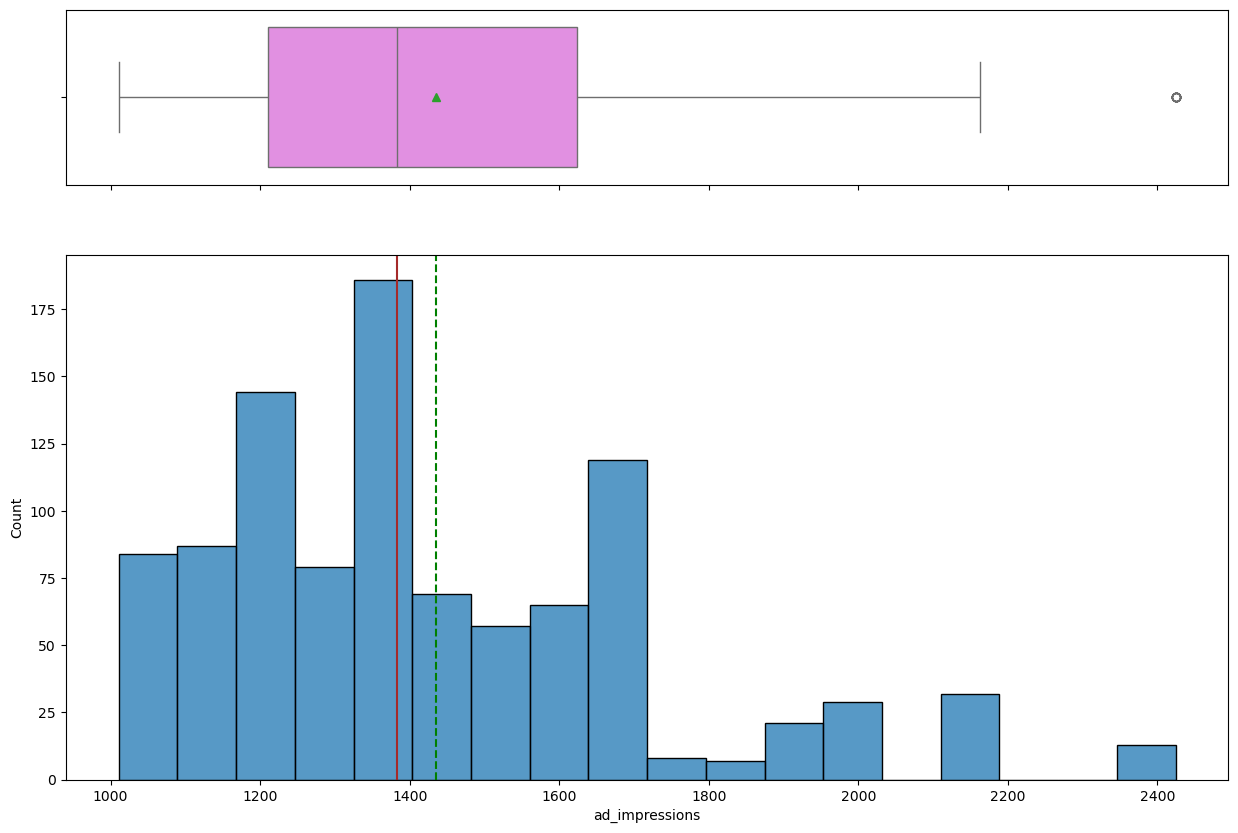

In [162]:
histogram_boxplot(data=df_ott, feature='ad_impressions')

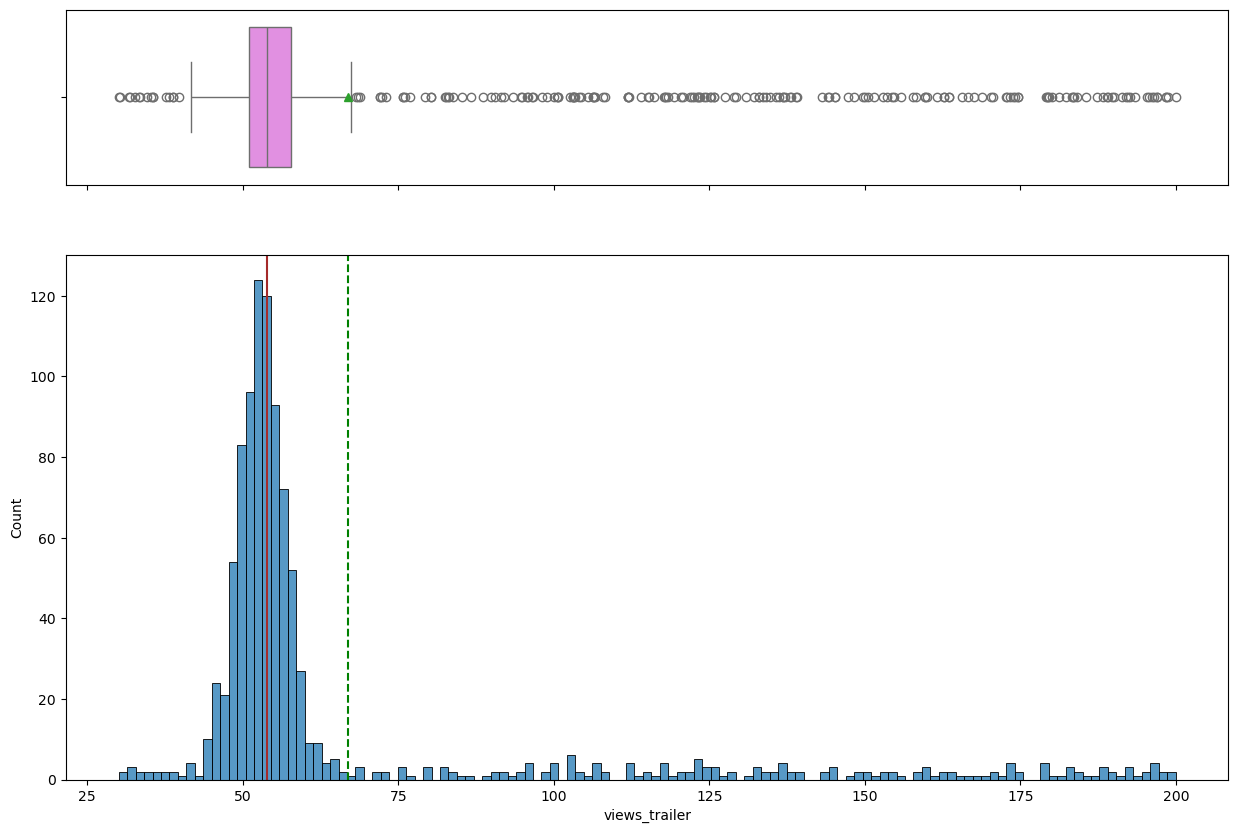

In [163]:
histogram_boxplot(data=df_ott, feature='views_trailer')

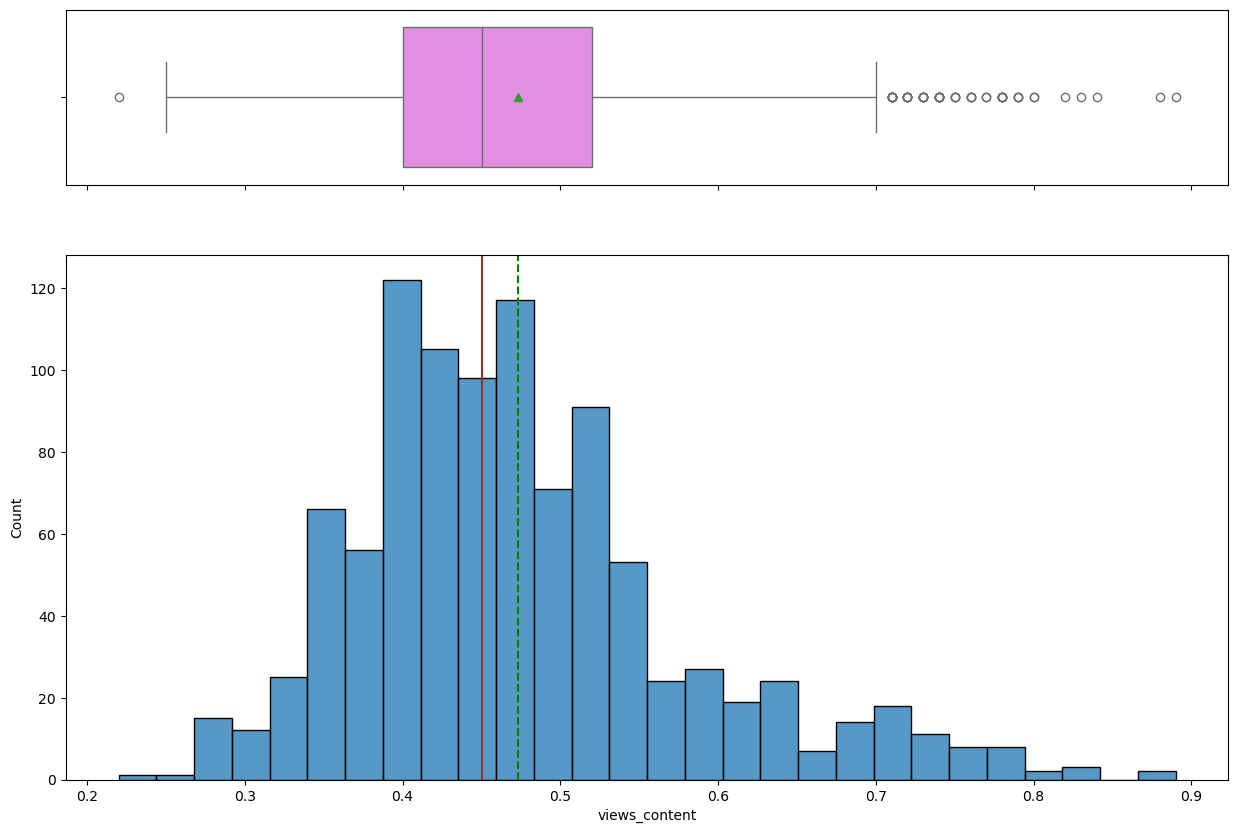

In [164]:
histogram_boxplot(data=df_ott, feature='views_content')

## Bivariate analysis

### Relationship between numerical columns

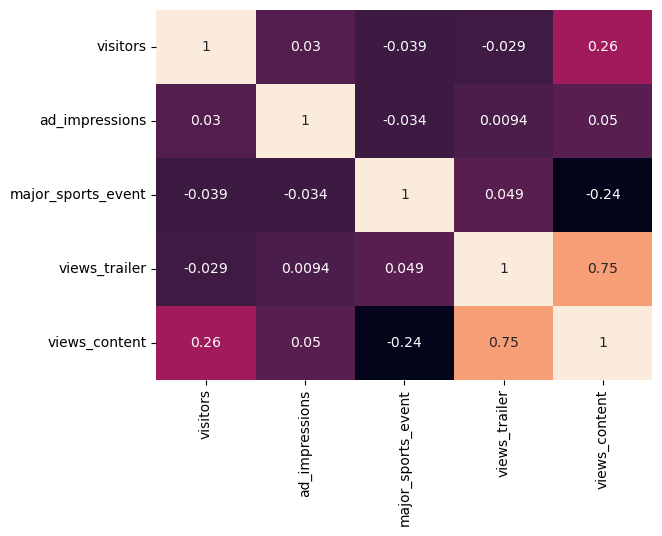

In [165]:
# Plot the correlation
numeric_cols = df_ott.select_dtypes(include=np.number).columns
sns.heatmap(df_ott[numeric_cols].corr(), annot=True, cbar=False)
plt.show()

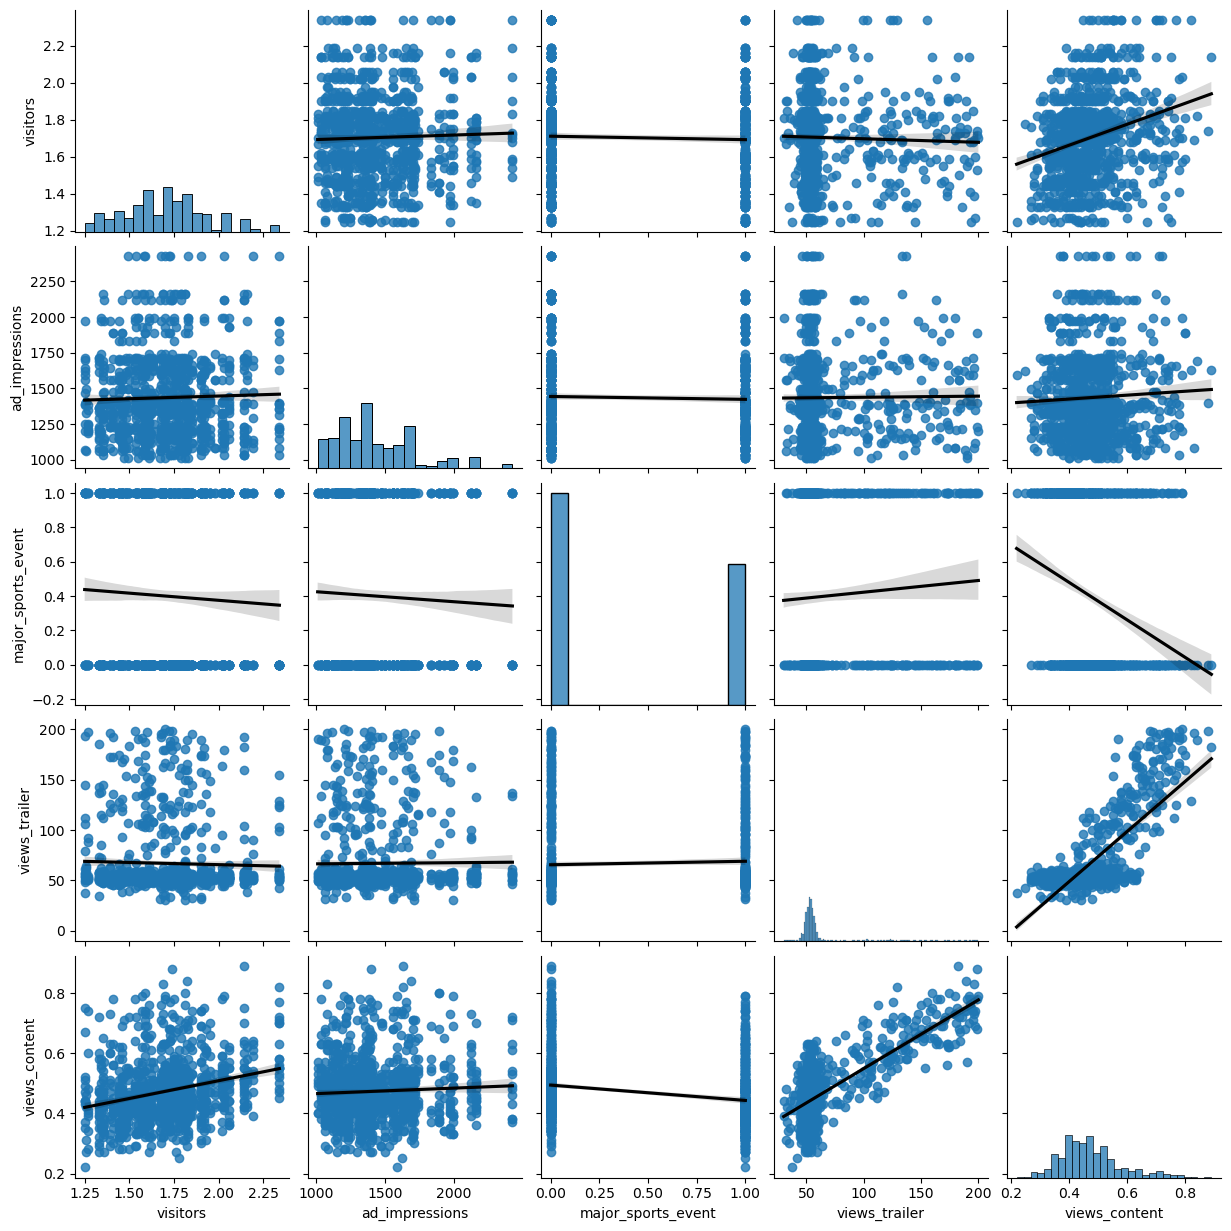

In [166]:
# Plot the combined scatter plot of all numeric columns
sns.pairplot(df_ott[numeric_cols], kind='reg', plot_kws={'line_kws': {'color': 'black'}})
plt.show()

### Relationship between categorical and numerical columns

Focus on views_content since that is the focus of analysis.

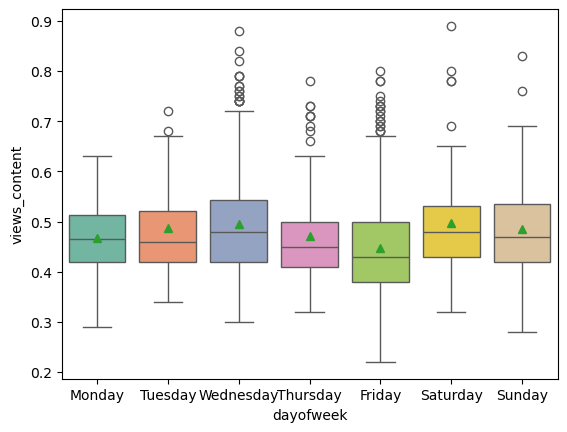

In [167]:
sns.boxplot(x='dayofweek', y='views_content', data=df_ott, showmeans=True, palette='Set2', order=days_order)
plt.show()

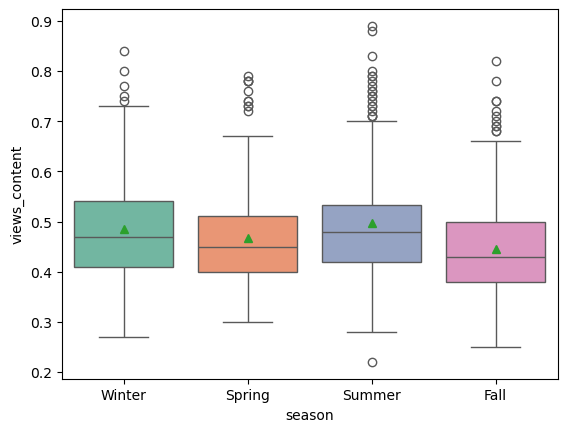

In [168]:
sns.boxplot(x='season', y='views_content', data=df_ott, showmeans=True, palette='Set2', order=season_order)
plt.show()

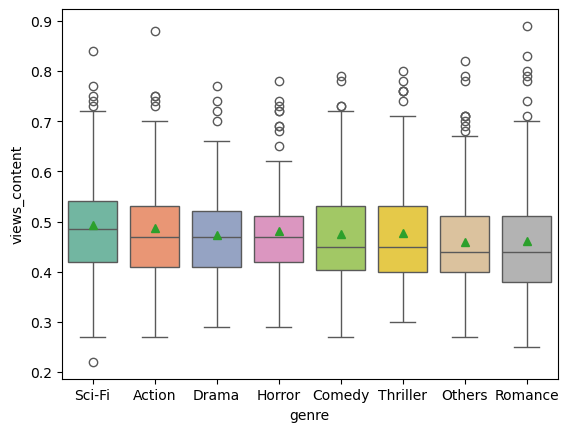

In [169]:
genreMedianOrder = df_ott.groupby('genre')['views_content'].median().sort_values(ascending=False).index
sns.boxplot(x='genre', y='views_content', data=df_ott, showmeans=True, palette='Set2', order=genreMedianOrder)
plt.show()

In [170]:
df_ott.groupby('genre')['views_content'].agg(['mean', 'median']).sort_values(by='mean', ascending=False).T

genre,Sci-Fi,Action,Horror,Thriller,Comedy,Drama,Romance,Others
mean,0.493235,0.487327,0.481089,0.476903,0.474211,0.473945,0.461238,0.459765
median,0.485000,0.470000,0.470000,0.450000,0.450000,0.470000,0.440000,0.440000


## Questions to be answered based on EDA

### Distribution of content views

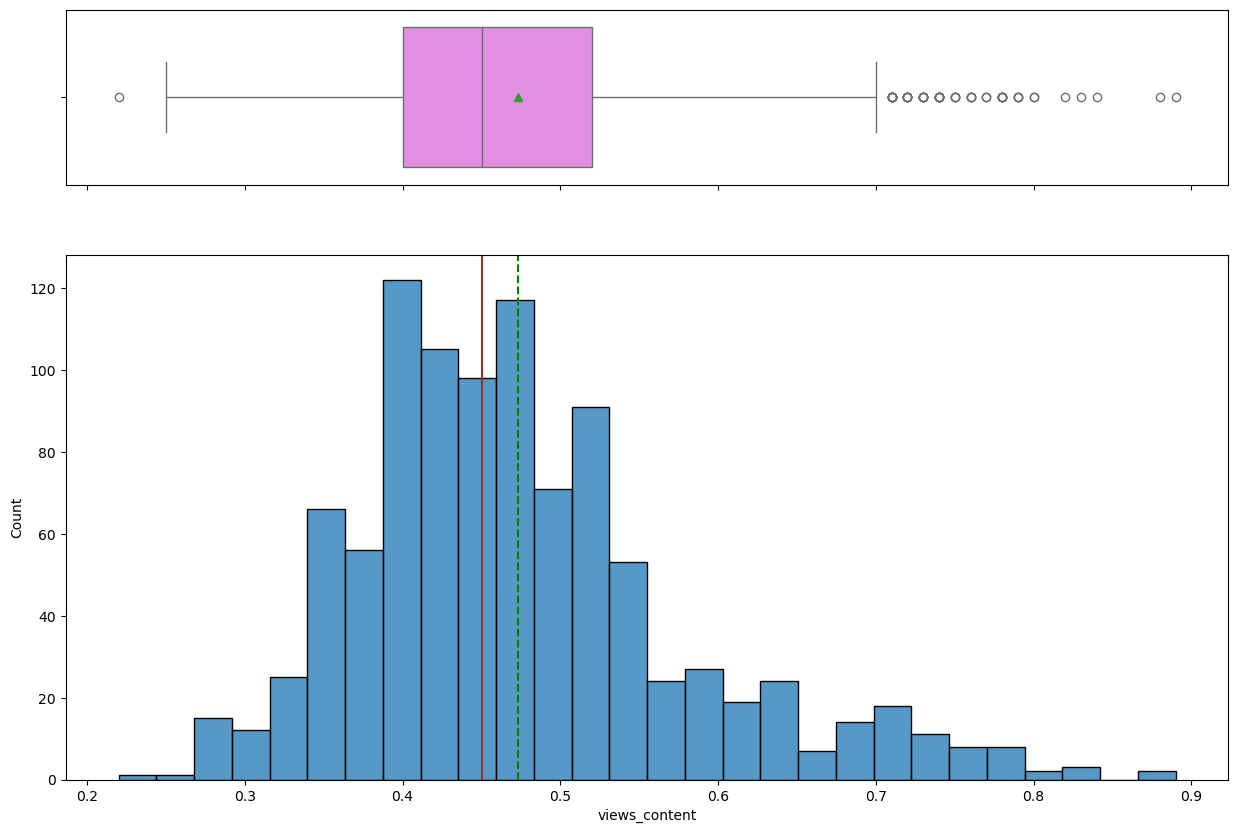

In [171]:
histogram_boxplot(data=df_ott, feature='views_content')

### Distribution of genres

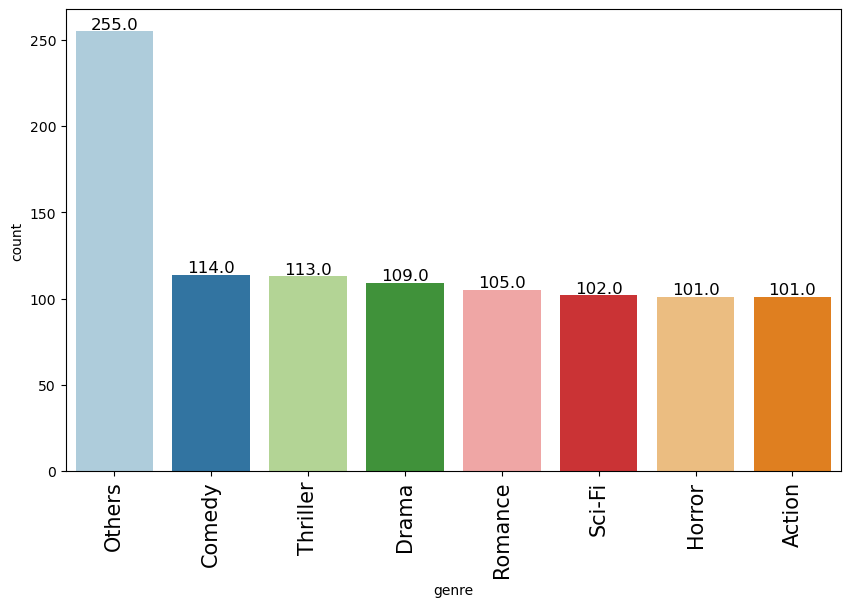

In [172]:
labeled_barplot(feature='genre', data=df_ott)

### Variation of viewership with the day of release

In [173]:
df_ott.groupby('dayofweek')['views_content'].agg(['mean', 'median']).sort_values(by='mean', ascending=False).T

dayofweek,Saturday,Wednesday,Tuesday,Sunday,Thursday,Monday,Friday
mean,0.497955,0.494608,0.487826,0.484179,0.470619,0.467917,0.446694
median,0.480000,0.480000,0.460000,0.470000,0.450000,0.465000,0.430000


### Variation of viewership with the season of release

In [174]:
df_ott.groupby('season')['views_content'].agg(['mean', 'median']).sort_values(by='mean', ascending=False).T

season,Summer,Winter,Spring,Fall
mean,0.496803,0.484669,0.467166,0.445357
median,0.480000,0.470000,0.450000,0.430000


### Correlation between trailer views and content views

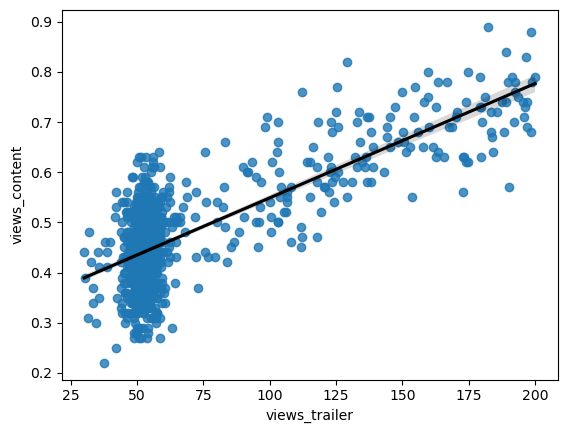

In [175]:
sns.regplot(data=df_ott, x='views_trailer', y='views_content', line_kws={'color': 'black'})
plt.show()

# Data preprocessing

## Duplicate value check

In [176]:
# Check for duplicates
df_ott.duplicated().sum() # No duplicates

0

## Missing value treatment

In [177]:
# Check for missing values
df_ott.isna().sum() # No missing values

visitors              0
ad_impressions        0
major_sports_event    0
genre                 0
dayofweek             0
season                0
views_trailer         0
views_content         0
dtype: int64

## Outlier treatment

In [178]:
# All outliers were valid values. So no treatment is needed.

## Feature engineering

In [179]:
# Create dummies for categorical columns
df_linreg = df_ott.copy()
df_linreg = pd.get_dummies(df_linreg, columns=['season', 'dayofweek', 'genre'])

In [180]:
df_linreg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   visitors             1000 non-null   float64
 1   ad_impressions       1000 non-null   float64
 2   major_sports_event   1000 non-null   int64  
 3   views_trailer        1000 non-null   float64
 4   views_content        1000 non-null   float64
 5   season_Fall          1000 non-null   bool   
 6   season_Spring        1000 non-null   bool   
 7   season_Summer        1000 non-null   bool   
 8   season_Winter        1000 non-null   bool   
 9   dayofweek_Friday     1000 non-null   bool   
 10  dayofweek_Monday     1000 non-null   bool   
 11  dayofweek_Saturday   1000 non-null   bool   
 12  dayofweek_Sunday     1000 non-null   bool   
 13  dayofweek_Thursday   1000 non-null   bool   
 14  dayofweek_Tuesday    1000 non-null   bool   
 15  dayofweek_Wednesday  1000 non-null   bo

In [181]:
# We need to drop 1 column from season, dayofweek and genre to avoid multicollinearity
# Let's drop Winter, Wednesday and Others
df_linreg = df_linreg.drop(['season_Winter', 'dayofweek_Wednesday', 'genre_Others'], axis = 1)
df_linreg.head()

,visitors,ad_impressions,major_sports_event,views_trailer,views_content,season_Fall,season_Spring,season_Summer,dayofweek_Friday,dayofweek_Monday,...,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,genre_Action,genre_Comedy,genre_Drama,genre_Horror,genre_Romance,genre_Sci-Fi,genre_Thriller
0,1.67,1113.81,0,56.70,0.51,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.46,1498.41,1,52.69,0.32,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
2,1.47,1079.19,1,48.74,0.39,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,1.85,1342.77,1,49.81,0.44,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
4,1.46,1498.41,0,55.83,0.46,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False


## Data preparation for modeling

In [182]:
# Prepare for linear regression
y = df_linreg['views_content']
X = df_linreg.drop('views_content', axis=1)
X = sm.add_constant(X)
X = X.astype(float)

In [183]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Model Building

## Linear regression

In [184]:
# Build and train model
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     129.0
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          1.32e-215
Time:                        14:25:02   Log-Likelihood:                 1124.6
No. Observations:                 700   AIC:                            -2207.
Df Residuals:                     679   BIC:                            -2112.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1410      0

In [185]:
# Ensure there is no multicollinearity
vif_series = pd.Series([ round(variance_inflation_factor(X_train.values, i) ,3) for i in range(X_train.shape[1])], index=X_train.columns)
print(vif_series)

const                 93.841
visitors               1.028
ad_impressions         1.029
major_sports_event     1.066
views_trailer          1.024
season_Fall            1.542
season_Spring          1.536
season_Summer          1.534
dayofweek_Friday       1.328
dayofweek_Monday       1.063
dayofweek_Saturday     1.164
dayofweek_Sunday       1.153
dayofweek_Thursday     1.183
dayofweek_Tuesday      1.062
genre_Action           1.340
genre_Comedy           1.349
genre_Drama            1.358
genre_Horror           1.331
genre_Romance          1.291
genre_Sci-Fi           1.336
genre_Thriller         1.341
dtype: float64


In [186]:
# Check significance of features
# Ad impressions has a high p-value. Let's drop it and build the model again.
X_train1 = X_train.drop('ad_impressions', axis=1)
ols_model1 = sm.OLS(y_train, X_train1).fit()
print(ols_model1.summary()) # No drop in Adj R-squared

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     135.9
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          1.29e-216
Time:                        14:25:02   Log-Likelihood:                 1124.5
No. Observations:                 700   AIC:                            -2209.
Df Residuals:                     680   BIC:                            -2118.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1462      0

In [187]:
# p-value for all genre columns are greater than 0.05
# Since it is a dummy variable, let's drop all of them.
genre_columns = [ col for col in X_train1.columns if (col.find('genre_') != -1) ] 
X_train2 = X_train1.drop(genre_columns, axis = 1)
ols_model2 = sm.OLS(y_train, X_train2).fit()
print(ols_model2.summary()) # No drop in Adj R-squared

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     215.2
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          2.28e-223
Time:                        14:25:02   Log-Likelihood:                 1121.8
No. Observations:                 700   AIC:                            -2218.
Df Residuals:                     687   BIC:                            -2158.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1503      0

In [188]:
# Drop season_Spring since p > 0.05
X_train3 = X_train2.drop('season_Spring', axis = 1)
ols_model3 = sm.OLS(y_train, X_train3).fit()
print(ols_model3.summary()) # No drop in Adj R-squared

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     234.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          2.31e-224
Time:                        14:25:02   Log-Likelihood:                 1121.3
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     688   BIC:                            -2164.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1465      0

In [189]:
# Drop dayofweek_Monday since p > 0.05
X_train4 = X_train3.drop('dayofweek_Monday', axis = 1)
ols_model4 = sm.OLS(y_train, X_train4).fit()
print(ols_model4.summary()) # No drop in Adj R-squared

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     257.9
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          2.89e-225
Time:                        14:25:02   Log-Likelihood:                 1120.6
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     689   BIC:                            -2169.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1459      0

In [190]:
# Drop dayofweek_Monday since p > 0.05
X_train5 = X_train4.drop('dayofweek_Sunday', axis = 1)
ols_model5 = sm.OLS(y_train, X_train5).fit()
print(ols_model5.summary()) # No drop in Adj R-squared

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     285.9
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          4.87e-226
Time:                        14:25:02   Log-Likelihood:                 1119.5
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     690   BIC:                            -2173.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1445      0

In [191]:
# Drop dayofweek_Monday since p > 0.05
X_train6 = X_train5.drop('dayofweek_Tuesday', axis = 1)
ols_model6 = sm.OLS(y_train, X_train6).fit()
print(ols_model6.summary()) # No drop in Adj R-squared
# All p-values are less than 0.05. This will be our final model

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     320.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          7.75e-227
Time:                        14:25:02   Log-Likelihood:                 1118.4
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     691   BIC:                            -2178.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1444      0

## Model statistics

In [192]:
# Final model ols_model3
ols_model_final = ols_model6
X_train_final = X_train6.copy()
print(ols_model_final.summary())

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     320.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          7.75e-227
Time:                        14:25:02   Log-Likelihood:                 1118.4
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     691   BIC:                            -2178.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1444      0

## Display model coefficient with column names

In [193]:
# Let us write the equation of linear regression
Equation = "views_content ="
print(Equation, end=" ")
for i in range(len(X_train_final.columns)):
    if i == 0:
        print(round(ols_model_final.params[i],3), "+", end=" ")
    elif i != len(X_train_final.columns) - 1:
        print(
            "(",
            round(ols_model_final.params[i],3),
            ")*(",
            X_train_final.columns[i],
            ")",
            "+",
            end=" ",
        )
    else:
        print("(", round(ols_model_final.params[i],3), ")*(", X_train_final.columns[i], ")")

views_content = 0.144 + ( 0.128 )*( visitors ) + ( -0.06 )*( major_sports_event ) + ( 0.002 )*( views_trailer ) + ( -0.025 )*( season_Fall ) + ( 0.019 )*( season_Summer ) + ( -0.044 )*( dayofweek_Friday ) + ( 0.014 )*( dayofweek_Saturday ) + ( -0.027 )*( dayofweek_Thursday )


# Perform tests for the assumptions of the linear regression

Assumptions of Linear Regression

These assumptions are essential conditions that should be met before we draw inferences regarding the model estimates or use the model to make a prediction.

For Linear Regression, we need to check if the following assumptions hold:-

1. Linearity
2. Independence
3. Homoscedasticity
4. Normality of error terms
5. No strong Multicollinearity

In [194]:
# Create a dataframe for testing the assumptions
df_pred = pd.DataFrame()

df_pred['Actual values'] = y_train.values.flatten() #actual values
df_pred['Fitted values'] = ols_model_final.fittedvalues.values # predicted values
df_pred['Residuals'] = ols_model_final.resid.values # residuals
df_pred.head()

,Actual values,Fitted values,Residuals
0,0.40,0.445045,-0.045045
1,0.70,0.670416,0.029584
2,0.42,0.433773,-0.013773
3,0.55,0.558161,-0.008161
4,0.59,0.546092,0.043908


## Test for Linearity and Independence

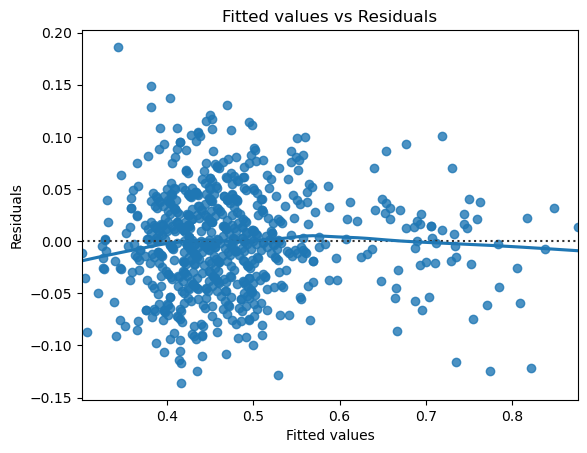

In [195]:
sns.residplot(data = df_pred, x = 'Fitted values', y = 'Residuals', lowess=True)
plt.title('Fitted values vs Residuals')
plt.show()

## Test for normality

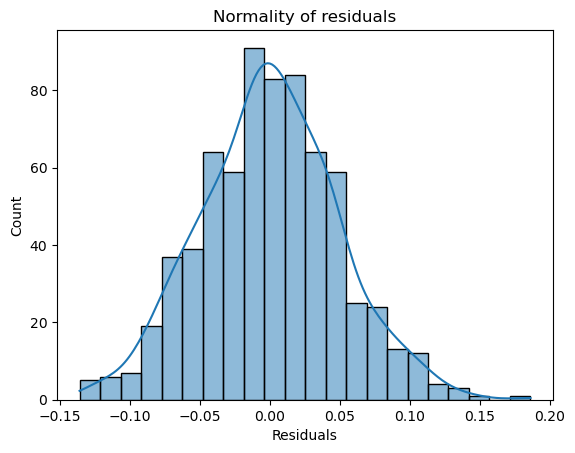

In [196]:
sns.histplot(df_pred["Residuals"], kde=True)
plt.title("Normality of residuals")
plt.show()

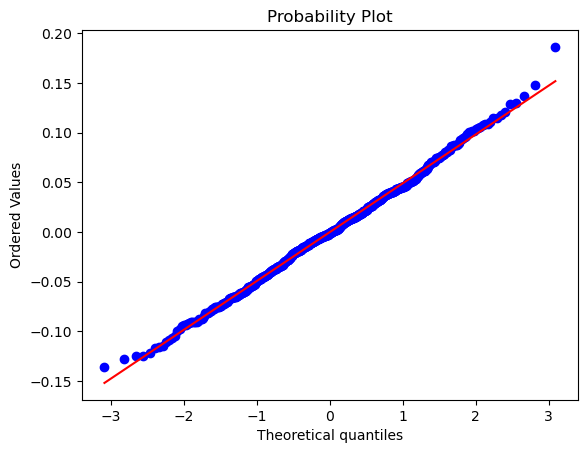

In [197]:
stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

In [198]:
# Shapiro test
stats.shapiro(df_pred["Residuals"])

ShapiroResult(statistic=0.9975436497017788, pvalue=0.39097919780727064)

## Test for homoscedasticity

In [209]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train_final)
lzip(name, test)

[('F statistic', 1.1127747705444562), ('p-value', 0.1621498820920906)]

# Model performance evaluation


In [200]:
# Drop the columns in test data so that the columns match with train data
colsToDrop = [ col for col in X_test.columns if col not in X_train_final.columns ]
X_test_final = X_test.drop(colsToDrop ,axis = 1)

In [201]:
# Predict the values on test dataset
y_test_pred = ols_model_final.predict(X_test_final)

In [202]:
# Root mean square error on training dataset
rmse_train = root_mean_squared_error(y_train, df_pred['Fitted values'])
round(rmse_train, 4)

0.049

In [203]:
# Root mean square error on test dataset
rmse_test = root_mean_squared_error(y_test, y_test_pred)
round(rmse_test, 4)

0.0511

In [204]:
# Mean absolute error on training dataset
mae_train = mean_absolute_error(y_train, df_pred['Fitted values'])
round(mae_train, 4)

0.0385

In [205]:
# Mean absolute error on training dataset
mae_test = mean_absolute_error(y_test, y_test_pred)
round(mae_test, 4)

0.0413

In [206]:
r2_score_train = r2_score(y_train, df_pred['Fitted values'])
round(r2_score_train, 4)

0.7879

In [207]:
r2_score_test = r2_score(y_test, y_test_pred)
round(r2_score_test, 4)

0.7621

In [208]:
print(ols_model_final.summary())

                            OLS Regression Results                            
Dep. Variable:          views_content   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     320.8
Date:                Wed, 26 Feb 2025   Prob (F-statistic):          7.75e-227
Time:                        14:25:02   Log-Likelihood:                 1118.4
No. Observations:                 700   AIC:                            -2219.
Df Residuals:                     691   BIC:                            -2178.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1444      0